In [1]:
import argparse
import gc
import logging
import os
import sys
import time

from collections import defaultdict

import torch
import torch.nn as nn
import torch.optim as optim

from sgan.data.loader import data_loader
from sgan.losses_argo import gan_g_loss, gan_d_loss, l2_loss
from sgan.losses_argo import displacement_error, final_displacement_error

from sgan.models_argo import TrajectoryGenerator, TrajectoryDiscriminator
from sgan.utils import int_tuple, bool_flag, get_total_norm
from sgan.utils import relative_to_abs, get_dset_path

from sgan.data.data import Argoverse_Social_Data, collate_traj_social
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

import numpy as np
torch.backends.cudnn.benchmark = True


In [2]:
def init_weights(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        nn.init.kaiming_normal_(m.weight)
        
def get_dtypes(use_gpu=True):
    long_dtype = torch.LongTensor
    float_dtype = torch.FloatTensor
    if use_gpu == 1:
        long_dtype = torch.cuda.LongTensor
        float_dtype = torch.cuda.FloatTensor
    return long_dtype, float_dtype        

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
long_dtype, float_dtype = get_dtypes()

argoverse_val   = Argoverse_Social_Data('../../deep_prediction/data/val/data')
argoverse_test  = Argoverse_Social_Data('../../deep_prediction/data/test_obs/data')

In [4]:
batch_size = 32
val_loader = DataLoader(argoverse_val, batch_size=batch_size,
                    shuffle=True, num_workers=2,collate_fn=collate_traj_social)
test_loader = DataLoader(argoverse_test, batch_size=batch_size,
                shuffle=True, num_workers=2,collate_fn=collate_traj_social)

In [5]:
generator = TrajectoryGenerator(
    obs_len=20,
    pred_len=30,
    embedding_dim=16,
    encoder_h_dim=32,
    decoder_h_dim=32,
    mlp_dim=64,
    num_layers=1,
    noise_dim=(8, ),
    noise_type='gaussian',
    noise_mix_type='global',
    pooling_type='pool_net',
    pool_every_timestep=0,
    dropout=0,
    bottleneck_dim=32,
    neighborhood_size=2.0,
    grid_size=8,
    batch_norm=False)

In [6]:
generator.apply(init_weights)
generator.type(float_dtype).train()

TrajectoryGenerator(
  (encoder): Encoder(
    (encoder): LSTM(16, 32)
    (spatial_embedding): Linear(in_features=2, out_features=16, bias=True)
  )
  (decoder): Decoder(
    (decoder): LSTM(16, 32)
    (spatial_embedding): Linear(in_features=2, out_features=16, bias=True)
    (hidden2pos): Linear(in_features=32, out_features=2, bias=True)
  )
  (pool_net): PoolHiddenNet(
    (spatial_embedding): Linear(in_features=2, out_features=16, bias=True)
    (mlp_pre_pool): Sequential(
      (0): Linear(in_features=48, out_features=512, bias=True)
      (1): ReLU()
      (2): Linear(in_features=512, out_features=32, bias=True)
      (3): ReLU()
    )
  )
  (mlp_decoder_context): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=24, bias=True)
    (3): ReLU()
  )
)

In [7]:
output_dir = os.getcwd()
checkpoint_name = 'gan_test'
restore_path = os.path.join(output_dir,'%s_with_model.pt' % checkpoint_name)
restore_path

'/home/sapanagrawal777/sgan/scripts/gan_test_with_model.pt'

In [8]:
checkpoint = torch.load(restore_path)
generator.load_state_dict(checkpoint['g_state'])

<All keys matched successfully>

In [9]:
def poly_fit(traj, traj_len=30, threshold=0.002):
    """
    Input:
    - traj: Numpy array of shape (2, traj_len)
    - traj_len: Len of trajectory
    - threshold: Minimum error to be considered for non linear traj
    Output:
    - int: 1 -> Non Linear 0-> Linear
    """
    t = np.linspace(0, traj_len - 1, traj_len)
    res_x = np.polyfit(t, traj[:, 0], 2, full=True)[1]
    res_y = np.polyfit(t, traj[:, 1], 2, full=True)[1]
    
    if res_x + res_y >= threshold:
        return 1.0
    else:
        return 0.0

In [10]:
dataiter = iter(val_loader)
batch = dataiter.next()

train_agent = batch['train_agent']
gt_agent = batch['gt_agent']
neighbour = batch['neighbour']
neighbour_gt = batch['neighbour_gt']
seq_path = batch['seq_path']

obs_traj = train_agent[0].unsqueeze(0)
obs_traj = torch.cat((obs_traj, neighbour[0]),0)

pred_traj_gt = gt_agent[0].unsqueeze(0)
pred_traj_gt = torch.cat((pred_traj_gt, neighbour_gt[0]),0)

ped_count = obs_traj.shape[0]
seq_start_end = [[0, ped_count]] # last number excluded

non_linear_ped = []
_non_linear_ped = [poly_fit(np.array(gt_agent[0]))]

for j in range(ped_count-1):
    _non_linear_ped.append(poly_fit(np.array(neighbour_gt[0][j])))
non_linear_ped += _non_linear_ped

for i in range(1, len(neighbour)):
    obs_traj = torch.cat((obs_traj, train_agent[i].unsqueeze(0)), 0)
    obs_traj = torch.cat((obs_traj, neighbour[i]), 0)

    pred_traj_gt = torch.cat((pred_traj_gt, gt_agent[i].unsqueeze(0)), 0)
    pred_traj_gt = torch.cat((pred_traj_gt, neighbour_gt[i]), 0)

    seq_start_end.append([ped_count, obs_traj.shape[0]])

    num_peds_considered = obs_traj.shape[0] - ped_count
    ped_count = obs_traj.shape[0]

    _non_linear_ped = [poly_fit(np.array(gt_agent[i]))]

    for j in range(num_peds_considered-1):
        _non_linear_ped.append(poly_fit(np.array(neighbour_gt[i][j])))

    non_linear_ped += _non_linear_ped

obs_traj_rel = torch.zeros(obs_traj.shape)
obs_traj_rel[:,1:,:] = obs_traj[:,1:,:] -  obs_traj[:,:-1,:]    

pred_traj_gt_rel = torch.zeros(pred_traj_gt.shape)
pred_traj_gt_rel[:,1:,:] = pred_traj_gt[:,1:,:] - pred_traj_gt[:,0:-1,:]

seq_start_end = torch.tensor(seq_start_end)
non_linear_ped = torch.tensor(non_linear_ped).cuda()

## 
obs_traj = obs_traj.transpose_(0,1).cuda() 
obs_traj_rel = obs_traj_rel.transpose_(0,1).cuda() 
pred_traj_gt = pred_traj_gt.transpose_(0,1).cuda() 
pred_traj_gt_rel = pred_traj_gt_rel.transpose_(0,1).cuda() 

################################################################

linear_ped = 1 - non_linear_ped

loss_mask = torch.ones(pred_traj_gt.shape[1],30).cuda()

pred_traj_fake_rel = generator(obs_traj, obs_traj_rel, seq_start_end)
pred_traj_fake = relative_to_abs(pred_traj_fake_rel, obs_traj[-1])

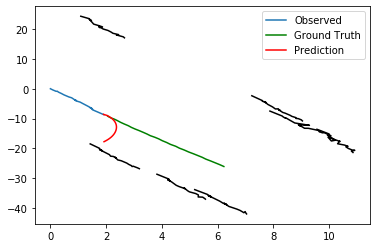

In [44]:
from matplotlib import pyplot as plt
obs_traj_ = np.array(obs_traj.cpu())
pred_traj_gt_ = np.array(pred_traj_gt.cpu())
pred_traj_fake_ = pred_traj_fake.cpu().detach().numpy()

j = 31

i = seq_start_end[j][0]

plt.plot(obs_traj_[:,i,0],obs_traj_[:,i,1], label="Observed")
plt.plot(pred_traj_gt_[:,i,0],pred_traj_gt_[:,i,1], 'g', label="Ground Truth")
plt.plot(pred_traj_fake_[:,i,0],pred_traj_fake_[:,i,1], 'r', label="Prediction")

for ped in range(i+1, seq_start_end[j][1]):
    plt.plot(obs_traj_[:,ped,0],obs_traj_[:,ped,1], 'k')
    
plt.legend()
plt.show()

In [ ]:
from argoverse.map_representation.map_api import ArgoverseMap
from argoverse.data_loading.argoverse_forecasting_loader import ArgoverseForecastingLoader
from argoverse.visualization.visualize_sequences import viz_sequence
avm = ArgoverseMap()

argoverse_forecasting_loader = ArgoverseForecastingLoader('../../deep_prediction/data/val/data/') #simply change to your local path of the data

In [ ]:
print(argoverse_forecasting_loader[0])
viz_sequence(argoverse_forecasting_loader[0].seq_df, show=True)